In [1]:
# imports
import os
import sys
import dvc.api
import mlflow
import pandas as pd
import joblib
import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, cross_validate
import warnings
warnings.filterwarnings('ignore')

In [2]:
# adding and setting up scripts
sys.path.append('.')
sys.path.append('..')
sys.path.insert(1, '../scripts/')
import defaults as defs
import dataCleaner as dc
import dataVisualizer as dv

cleaner = dc.dataCleaner('base-line modeling notebook')
visualizer = dv.dataVisualizer('base-line modeling notebook')

--> <Logger dataCleaner (WARNING)>
logger <Logger dataCleaner (DEBUG)> created at path: ../logs/cleaner_root.log
Data cleaner in action
--> <Logger dataVisualizer (WARNING)>
logger <Logger dataVisualizer (DEBUG)> created at path: ../logs/visualizer_root.log
Data visualizer in action


In [3]:
# pandas settings
pd.set_option('display.max_columns', 30)

# version of the data
# v1 : gdrive 
# v2 : local messed up store
# v3 : local correct store
# v4 : local store: merged data file generated, data preparation completed
version = 'v4'

# read data sets using dvc api
test_data_url = dvc.api.get_url(path = defs.test_local_path, 
                                repo = defs.repo, 
                                rev = version)

train_data_url = dvc.api.get_url(path = defs.train_local_path, 
                                repo = defs.repo, 
                                rev = version)

"""store_data_url = dvc.api.get_url(path = defs.store_local_path, 
                                repo = defs.repo, 
                                rev = version)"""

full_data_url = dvc.api.get_url(path = defs.merged_local_path, 
                                repo = defs.repo, 
                                rev = version)
"""print('test data path: ' + test_data_url, '\ntrain data path: ' + train_data_url, '\nstore data path: ' + store_data_url, '\nmerged data path: ' + full_data_url)"""

print('test data path: ' + test_data_url, '\ntrain data path: ' + train_data_url, '\nmerged data path: ' + full_data_url)

test data path: /.dvc/C:\Users\f0x-tr0t\Documents\education\datascience\dvc-storage/d5/d6373bc6743cde41c22b4599dce90c 
train data path: /.dvc/C:\Users\f0x-tr0t\Documents\education\datascience\dvc-storage/1f/38ace4291877fe3b742e8b7a111377 
merged data path: /.dvc/C:\Users\f0x-tr0t\Documents\education\datascience\dvc-storage/2c/45c8bfea2787f193cb56fe88d8df04


In [4]:
# reading csv files
DateCols = ['Date']
missing_values = ["n/a", "na", "undefined", '?', 'NA', 'undefined']

"""test_data = pd.read_csv(test_data_url, na_values=missing_values, parse_dates=DateCols, low_memory=False)
train_data = pd.read_csv(train_data_url, na_values=missing_values, parse_dates=DateCols, low_memory=False)
full_data = pd.read_csv(full_data_url, na_values=missing_values, parse_dates=DateCols, low_memory=False)
store_data = pd.read_csv(store_data_url, na_values=missing_values, low_memory=False)"""

test_data = pd.read_csv(defs.test_local_path, na_values=missing_values, parse_dates=DateCols)
train_data = pd.read_csv(defs.train_local_path, na_values=missing_values, parse_dates=DateCols)
full_data = pd.read_csv(defs.merged_local_path, na_values=missing_values, parse_dates=DateCols)

# Base line modeling

In [5]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 27 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  int64         
 8   SchoolHoliday              1017209 non-null  int64         
 9   Year                       1017209 non-null  int64         
 10  Month                      1017209 non-null  int64         
 11  DayOfMonth                 1017209 no

In [6]:
full_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'DayOfMonth',
       'WeekOfYear', 'weekday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'PromoInterval0', 'PromoInterval1',
       'PromoInterval2', 'PromoInterval3'],
      dtype='object')

In [7]:
full_data.weekday.value_counts()

1    727749
0    289460
Name: weekday, dtype: int64

* As we can see all of the data preprocessing tasks of this project were handled prior to this stage.
* The data preprocessing phase has been completed in the data preparation stage.

*  Every data type in full data set is numerical and good to go to ml

In [8]:
# setting up mlflow experiment
mlflow.set_experiment('base line modeling')
mlflow.start_run()

mlflow.log_param('full data columns', full_data.columns.to_list())
mlflow.log_param('full data shape', full_data.shape)
mlflow.log_param('full data version', version)
mlflow.log_param('full data input_rows', full_data.shape[0])
mlflow.log_param('full data input_cols', full_data.shape[1])

"""mlflow.log_param('store data columns', store_data.columns.to_list())
mlflow.log_param('store data shape', store_data.shape)
mlflow.log_param('store data version', version)
mlflow.log_param('store data input_rows', store_data.shape[0])
mlflow.log_param('store data input_cols', store_data.shape[1])"""

mlflow.log_param('test data columns', test_data.columns.to_list())
mlflow.log_param('test data shape', test_data.shape)
mlflow.log_param('test data version', version)
mlflow.log_param('test data input_rows', test_data.shape[0])
mlflow.log_param('test data input_cols', test_data.shape[1])

In [9]:
print(f"lowest date: {train_data['Date'].min()}, highest date: {train_data['Date'].max()}")

lowest date: 2013-01-01 00:00:00, highest date: 2015-07-31 00:00:00


* We have 31 months of data.

## Setting up pipelines and building the model

### Set up the dataset

In [11]:
train_data_ts = train_data.copy()

In [12]:
train_data_ts

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfMonth,WeekOfYear,weekday
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,1
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,1
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,1
3,4,5,2015-07-31,13995,609,1,1,0,1,2015,7,31,31,1
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,1,1,2013,1,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,1,1,2013,1,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,1,1,2013,1,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,1,1,2013,1,1,1,1


In [13]:
X_train = train_data_ts.loc[train_data_ts['Date']<'2015-01-01']
X_test = train_data_ts.loc[train_data_ts['Date']>='2015-01-01']

In [14]:
X_train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfMonth,WeekOfYear,weekday
236380,1,3,2014-12-31,2605,327,1,0,0,1,2014,12,31,1,1
236381,2,3,2014-12-31,2269,252,1,0,0,1,2014,12,31,1,1
236382,3,3,2014-12-31,3804,408,1,0,0,1,2014,12,31,1,1
236383,4,3,2014-12-31,10152,1311,1,0,0,1,2014,12,31,1,1
236384,5,3,2014-12-31,1830,217,1,0,0,1,2014,12,31,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,1,1,2013,1,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,1,1,2013,1,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,1,1,2013,1,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,1,1,2013,1,1,1,1


In [15]:
X_test

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfMonth,WeekOfYear,weekday
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,1
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,1
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,1
3,4,5,2015-07-31,13995,609,1,1,0,1,2015,7,31,31,1
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236375,1111,4,2015-01-01,0,0,0,0,1,1,2015,1,1,1,1
236376,1112,4,2015-01-01,0,0,0,0,1,1,2015,1,1,1,1
236377,1113,4,2015-01-01,0,0,0,0,1,1,2015,1,1,1,1
236378,1114,4,2015-01-01,0,0,0,0,1,1,2015,1,1,1,1


In [16]:
X_train['Year'].value_counts()

2013    406974
2014    373855
Name: Year, dtype: int64

In [17]:
X_test['Year'].value_counts()

2015    236380
Name: Year, dtype: int64

* We set up the training and testing data sets like this because this is a time series data set.
* We are going to use the data prior to 2015 as training and the data after 2015 as testing data.

In [18]:
print(f"X_train and X_test: {X_train.shape + X_test.shape},\nTOtal: {X_train.shape[0] + X_test.shape[0]}")

X_train and X_test: (780829, 14, 236380, 14),
TOtal: 1017209


* 780,829(X_train rows) + 236,380(X_test rows) = 1,017,209(total training data set rows)
* Train and test split account for all the data inside the training data set.

In [19]:
# setup train and test data
y_train = X_train.loc[ : , 'Sales']
X_train = X_train.drop(['Sales', 'Date'], axis=1)


y_test = X_test.loc[ : , 'Sales']
X_test = X_test.drop(['Sales', 'Date'], axis=1)

* We can drop the date feature because we refactored it to several other representative features adding even more features using it 

In [20]:
mlflow.log_param('features', X_train.columns.to_list())
mlflow.log_param('target', y_train)

### Create cross folds, pipelines, scoring, loss functions and models

In [21]:
# create standard scaler
std_scaler = StandardScaler()

# create the model parameters
rf_params = {'n_estimators': 50,'random_state': 777}
mlflow.log_param('random forest parameters', rf_params)

# create the model and set the parameters to the model
rf_model = RandomForestRegressor(n_estimators=50,
                                 random_state=777)

# create a pipeline
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
rf_pipe = Pipeline([('scaler', std_scaler),
                    ('random forest', rf_model)],
                     verbose=True)

# shuffle split using 5 folds and tet size of 20%
# TODO: increase the number of splits, made 3 here for other reasons
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=777)
mlflow.log_param('cross_validation', cv)

# Choosing loss functions for regression
scoring = ['r2', 'neg_mean_squared_error', 'accuracy', 'precision']
mlflow.log_param('scoring', scoring)

In [22]:
# random forest cross validation
rf_results = cross_validate(rf_pipe, X_train, y_train, cv=cv, scoring=scoring, 
                                return_train_score=True, return_estimator=True,
                                verbose=7)
# 5 cross folds - 49 min
# 3 cross folds - 13 min

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ..... (step 2 of 2) Processing random forest, total= 3.1min
[CV] END  accuracy: (train=nan, test=nan) neg_mean_squared_error: (train=nan, test=nan) precision: (train=nan, test=nan) r2: (train=nan, test=nan) total time= 3.2min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min remaining:    0.0s


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ..... (step 2 of 2) Processing random forest, total= 3.2min
[CV] END  accuracy: (train=nan, test=nan) neg_mean_squared_error: (train=nan, test=nan) precision: (train=nan, test=nan) r2: (train=nan, test=nan) total time= 4.9min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.8min remaining:    0.0s


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   4.0s
[Pipeline] ..... (step 2 of 2) Processing random forest, total= 3.3min
[CV] END  accuracy: (train=nan, test=nan) neg_mean_squared_error: (train=nan, test=nan) precision: (train=nan, test=nan) r2: (train=nan, test=nan) total time= 3.5min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.8min finished


### Fit the model and get scores

In [22]:
# fit the pipeline
rf_pipe._final_estimator.fit(X_train, y_train)
# took 3min 40sec with 50 as the default n_estimators

# get the score
test_score = rf_pipe._final_estimator.score(X_test, y_test) 
test_score

0.9224562968773111

* Test score = 0.9225
* The default mse score of the random forest

### Feature importance

Importance: [9.99265769e-02 1.12632672e-02 8.32475549e-01 0.00000000e+00
 1.85560651e-02 2.38076090e-04 1.95858509e-03 3.22791637e-03
 5.88352318e-03 1.45731507e-02 1.11593890e-02 7.37901145e-04]


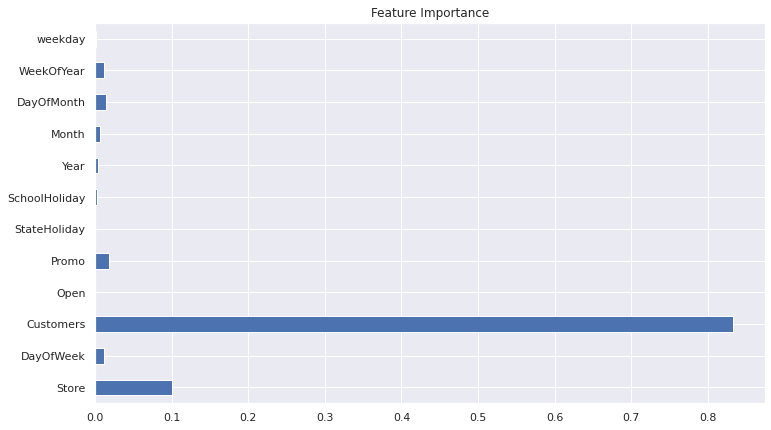

In [41]:
#importance = decision_tree_results['estimator'][i]['decision_tree_classifier'].feature_importances_
importance = rf_pipe._final_estimator.feature_importances_
print(f'Importance: {importance}')
#importance is a list so you can plot it.
plt.figure(figsize=(12, 7))
feat_importance = pd.Series(importance, index=X_train.columns)
# feat_importance.nlargest(20).plot(kind='barh',title = 'Feature Importance')
feat_importance.plot(kind='barh',title = 'Feature Importance')
plt.show()

##### According to the Random Forest Regressor model we just generated

* As we can see Customers and Store has the highest feature importance.
* While DayOfWeek, WeekofYear, DayOfMonth and promo also are among the feature importance.

### Save and log model

In [24]:
# get current data time
current_datetime = datetime.datetime.now()

# save the model
joblib.dump(rf_pipe._final_estimator, '../models/'
            + current_datetime.strftime("%Y-%m-%d-%H-%M-%S-")
            + 'rf_model.pkl') 
# 1min 30sec

mlflow.log_artifact('../models/'
            + current_datetime.strftime("%Y-%m-%d-%H-%M-%S-")
            + 'rf_model.pkl')

'mlflow.log_artifact(\'../models/\'\n            + current_datetime.strftime("%Y-%m-%d-%H-%M-%S")\n            + \'rf_model.pkl\')'

In [25]:
rf_pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('random forest',
                 RandomForestRegressor(n_estimators=50, random_state=777))],
         verbose=True)

In [26]:
rf_pipe._final_estimator

RandomForestRegressor(n_estimators=50, random_state=777)

In [27]:
def print_result (self, model_result : dict, scoring_metrics : list,
                      metrics_type : str) -> None:
        """
        A function for creating model result reports: Mean
        Parameters
        =--------=
        model_result: dict
            Result of the model
        scoring_metrics: list
            List of scoring metrics
        metrics_type: str
            String of the metics type
        Returns
        =-----=
        None: nothing
            It will only print out the results
        """
        if metrics_type == 'mean':
            print('\n--- Mean Report ---')
            self.logger.info('setting up mean report')
            print(f"fit time: {round(model_result['fit_time'].mean(), 4)}")
            self.logger.info(f"fit time: {round(model_result['fit_time'].mean(), 4)}")
            print(f"score time: {round(model_result['score_time'].mean(), 4)}")
            self.logger.info(f"score time: {round(model_result['score_time'].mean(), 4)}")
            for scores in scoring_metrics:
                #train_key = 'train_' + scores
                test_key = 'test_' + scores
                #print(f"{train_key}: {round(model_result[train_key].mean(), 4)}")
                print(f"{test_key}: {round(model_result[test_key].mean(), 4)}")
                self.logger.info(f"{test_key}: {round(model_result[test_key].mean(), 4)}")
        
        if metrics_type == 'std':
            print('\n--- Standard deviation Report ---')
            self.logger.info('setting up standard deviation report')
            print(f"fit time: {round(model_result['fit_time'].std(), 4)}")
            self.logger.info(f"fit time: {round(model_result['fit_time'].std(), 4)}")
            print(f"score time: {round(model_result['score_time'].std(), 4)}")
            self.logger.info(f"score time: {round(model_result['score_time'].std(), 4)}")
            for scores in scoring_metrics:
                #train_key = 'train_' + scores
                test_key = 'test_' + scores
                #print(f"{train_key}: {round(model_result[train_key].std(), 4)}")
                print(f"{test_key}: {round(model_result[test_key].std(), 4)}")
                self.logger.info(f"{test_key}: {round(model_result[test_key].std(), 4)}")

In [38]:
# rf_results

In [37]:
# print_result(rf_results, scoring, 'std')

In [39]:
# print_result(rf_results, scoring, 'mean')

### Predict the test data using the model

#### update the test dataset to use the same features as the train data

In [29]:
#test_data = transform_date_column(df = test_data, column = 'Date')

test_data['Year'] = test_data['Date'].apply(lambda x: x.year)
test_data['Month'] = test_data['Date'].apply(lambda x: x.month)
test_data['DayOfMonth'] = test_data['Date'].apply(lambda x: x.day)
test_data['WeekOfYear'] = test_data['Date'].apply(lambda x: x.weekofyear)
test_data['weekday'] = test_data['Date'].apply(lambda x: 0 if (x in [6, 7]) else 1)

test_data.drop(['Date', 'Id'], axis = 1, inplace = True)

In [30]:
train_data['Customers'].value_counts()#.max()

0      172869
609     40369
560      2414
576      2363
603      2337
        ...  
8           1
87          1
13          1
67          1
36          1
Name: Customers, Length: 1424, dtype: int64

In [31]:
test_data.shape

(41088, 11)

#### add customers feature, becaus the standard scaler expects the features to be the same

In [32]:
random_customers = pd.np.random.randint(low = 1, high = 172869, size = 41088)
test_data['Customers'] = random_customers
test_data

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfMonth,WeekOfYear,weekday,Customers
0,1,4,1,1,0,0,2015,9,17,38,1,53863
1,3,4,1,1,0,0,2015,9,17,38,1,84603
2,7,4,1,1,0,0,2015,9,17,38,1,134132
3,8,4,1,1,0,0,2015,9,17,38,1,60760
4,9,4,1,1,0,0,2015,9,17,38,1,23092
...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1111,6,1,0,0,0,2015,8,1,31,1,103862
41084,1112,6,1,0,0,0,2015,8,1,31,1,116327
41085,1113,6,1,0,0,0,2015,8,1,31,1,168909
41086,1114,6,1,0,0,0,2015,8,1,31,1,26764


In [33]:
y_pred = rf_pipe._final_estimator.predict(test_data)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

### Save prediction

In [40]:
# saving predictions
data = {"Id" : range(0,41088,1), "Sales" : y_pred}
predictions = pd.DataFrame(data = data)
predictions.to_csv('../predictions/'
                    + datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S-")
                    + 'rf_predictions.csv', index = False)
mlflow.log_param('rf predictions', predictions)

In [36]:
mlflow.end_run()